In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110
'''!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz'''

'!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz\n!gunzip -k methane.extxyz.gz'

In [2]:
import numpy as np
import ase.io
import tqdm
from matplotlib import pyplot as plt
import torch


torch.set_default_tensor_type(torch.DoubleTensor)
from torch import nn
import sys
sys.path.append('../code/')
from code_pytorch import *
from utilities import *
from miscellaneous import ClebschGordan

In [3]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'    
}
train_subset = '0:10000'
test_subset = '10000:11000'
DEVICE = 'cuda'
FIRST_BATCH_NORM_EPSILON = 1e-20 #spherical expansion coefficients from rascal might be really small!

In [4]:
train_structures = ase.io.read('../methane.extxyz', index=train_subset)

test_structures = ase.io.read('../methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_coefs(train_structures, HYPERS, all_species)
test_coefficients = get_coefs(test_structures, HYPERS, all_species)


for key in train_coefficients.keys():
    train_coefficients[key] = train_coefficients[key]
for key in test_coefficients.keys():
    test_coefficients[key] = test_coefficients[key]

In [5]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

train_energies = torch.FloatTensor(train_energies).to(DEVICE)
test_energies = torch.FloatTensor(test_energies).to(DEVICE)

train_forces = [structure.arrays["forces"] for structure in train_structures]
train_forces = np.concatenate(train_forces, axis = 0) * FORCE_FACTOR

test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR


coef_der_train, central_indices_train, derivative_indices_train = \
get_coef_ders(train_structures, HYPERS, all_species)
print(np.min(derivative_indices_train[0:12500]))
print(np.max(derivative_indices_train[0:12500]))
print(np.min(central_indices_train[0:12500]))
print(np.max(central_indices_train[0:12500]))

for key in coef_der_train.keys():
    coef_der_train[key] = coef_der_train[key]

    
coef_der_test, central_indices_test, derivative_indices_test = \
get_coef_ders(test_structures, HYPERS, all_species)


for key in coef_der_test.keys():
    coef_der_test[key] = coef_der_test[key]

0
2499
0
2499


In [6]:
def get_loss(predictions, targets):
    delta = predictions - targets
    return torch.mean(delta * delta)

def get_mae(first, second):
    return np.mean(np.abs(first - second))

def get_rmse(first, second):
    delta = first - second
    return np.sqrt(np.mean(delta * delta))

# The cell below is the only one that differs from previous notebook

In [7]:


class Model(torch.nn.Module):
    def __init__(self, input_lambda_max):
        super(Model, self).__init__()
        clebsch = ClebschGordan(input_lambda_max)
        self.clebsch_combining = ClebschCombining(clebsch.precomputed_, 0)
        self.sequential = nn.Sequential(nn.BatchNorm1d(600, eps = FIRST_BATCH_NORM_EPSILON), nn.Linear(600, 200), nn.BatchNorm1d(200), nn.Tanh(),
                                        nn.Linear(200, 200), nn.BatchNorm1d(200), nn.Tanh(),
                                        nn.Linear(200, 1))
        
    def forward(self, X):
        X = self.clebsch_combining(X, X)['0'].squeeze()        
        return {'predictions' : self.sequential(X).squeeze()}

![title](./snap.jpg)

In [8]:
model = Model(LAMBDA_MAX)
result = model(train_coefficients)
print(type(result))
print(result['predictions'].shape)

<class 'dict'>
torch.Size([50000])


In [9]:
models = {}
for key in all_species:
    models[str(key)] = Model(LAMBDA_MAX)
    

In [10]:
atomistic = Atomistic(models).to(DEVICE)
optim = torch.optim.Adam(atomistic.parameters())




train_struc = {'energies' : train_energies}
test_struc = {'energies' : test_energies}
#print(train_atomic[0].device)
#print(torch.is_tensor(train_atomic[0]))
BATCH_SIZE = 500
history = {'train_mae' : [], 'test_mae' : [],
           'train_rmse' : [], 'test_rmse' : []}
for epoch_num in range(100):
    train_predictions = []
    atomistic.train(True)
    for _, _, _, coef_batch, structural_batch, structures_batch in iterate_minibatches(None, None, None, train_coefficients, train_struc,
                                                  train_structures, BATCH_SIZE, DEVICE):
        energies_now = structural_batch['energies']
       
        predictions = atomistic(coef_batch, central_species = get_central_species(structures_batch),
                                structural_indices = get_structural_indices(structures_batch)
                               )['predictions'].squeeze()
        train_predictions.append(predictions.data.cpu().numpy())       
        loss = get_loss(predictions, energies_now)
        loss.backward()
        optim.step()
        optim.zero_grad()
    atomistic.train(False)
    train_predictions = np.concatenate(train_predictions, axis = 0)
    train_mae = get_mae(train_predictions, train_energies.data.cpu().numpy())
    train_rmse = get_rmse(train_predictions, train_energies.data.cpu().numpy())
    if epoch_num % 10 == 0:
        print("train mae: ", train_mae)
        print("train rmse: ", train_rmse)
        
    test_predictions = []
    for _, _, _, coef_batch, structural_batch, structures_batch in iterate_minibatches(None, None, None, test_coefficients, test_struc,
                                                   test_structures, BATCH_SIZE, DEVICE):
        
        energies_now = structural_batch['energies']
        predictions = atomistic(coef_batch, central_species = get_central_species(structures_batch),
                                structural_indices = get_structural_indices(structures_batch),
                                )['predictions'].squeeze()
        test_predictions.append(predictions.data.cpu().numpy())
    test_predictions = np.concatenate(test_predictions, axis = 0)
    test_mae = get_mae(test_predictions, test_energies.data.cpu().numpy())
    test_rmse = get_rmse(test_predictions, test_energies.data.cpu().numpy())
    if epoch_num % 10 == 0:
        print("test mae: ", test_mae)
        print("test rmse: ", test_rmse)
    history['train_mae'].append(train_mae)
    history['test_mae'].append(test_mae)
    history['train_rmse'].append(train_rmse)
    history['test_rmse'].append(test_rmse)

train mae:  1.162020101918701
train rmse:  1.884166846891656
test mae:  2.2032041813317482
test rmse:  3.530496329213985
train mae:  0.2708238307551795
train rmse:  0.37441391819359104
test mae:  2.6075732049211235
test rmse:  3.9770087902206877
train mae:  0.22942537987927702
train rmse:  0.30230506843895943
test mae:  1.1388074719181254
test rmse:  1.7321255745727084
train mae:  0.2228434538089583
train rmse:  0.3002741891935107
test mae:  0.2658837231666074
test rmse:  0.3898644258517902
train mae:  0.16761677388314397
train rmse:  0.21658902093585397
test mae:  0.23650987128582954
test rmse:  0.35312555577721
train mae:  0.28898634958792596
train rmse:  0.38803901348683917
test mae:  0.32331653876380606
test rmse:  0.47821024793893036
train mae:  0.22421668254578808
train rmse:  0.29894154005175777
test mae:  0.2650142584768322
test rmse:  0.39430927257462617
train mae:  0.2577224001434496
train rmse:  0.3556742172976336
test mae:  0.265194928161828
test rmse:  0.39441065382967117


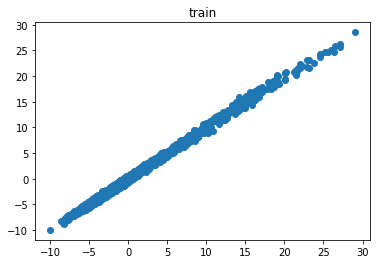

train rmse 0.22900960635083142
train mae:  0.17384518616651282


In [11]:
plt.plot(train_energies.data.cpu().numpy(), train_predictions, 'o')
plt.title("train")
plt.show()
print("train rmse", get_rmse(train_energies.data.cpu().numpy(), train_predictions))
print("train mae: ", get_mae(train_energies.data.cpu().numpy(), train_predictions))



test rmse 0.3189957511420484
test mae:  0.21333432171488226


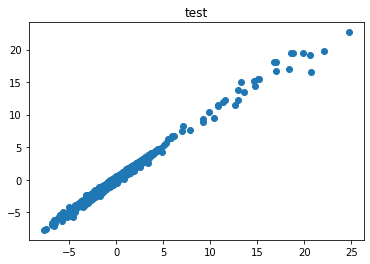

In [12]:
plt.plot(test_energies.data.cpu().numpy(), test_predictions, 'o')
plt.title("test")

print("test rmse", get_rmse(test_energies.data.cpu().numpy(), test_predictions))
print("test mae: ", get_mae(test_energies.data.cpu().numpy(), test_predictions))
plt.show()

In [13]:
atomistic = atomistic.train(False)

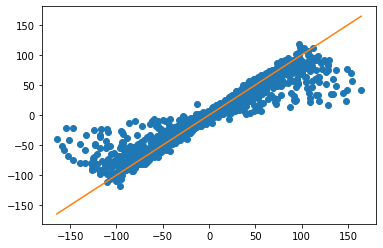

train mae:  0.4984655642897916
train rmse:  2.2704989042109394


In [14]:
forces_predictions_train = []
for key in train_coefficients.keys():
    train_coefficients[key].requires_grad = True
for coef_der_batch, central_batch, derivative_batch, coef_batch, _, structures_batch in iterate_minibatches(coef_der_train,
                                                    central_indices_train, derivative_indices_train, train_coefficients, None,
                                                   train_structures, BATCH_SIZE, DEVICE):
    forces_predictions_now = atomistic.get_forces(coef_der_batch, central_batch, derivative_batch,
                                                 coef_batch, get_central_species(structures_batch),
                                                  get_structural_indices(structures_batch))
    #print(forces_predictions_now.shape)
    forces_predictions_train.append(forces_predictions_now)
    
forces_predictions_train = torch.cat(forces_predictions_train, dim = 0)
forces_predictions_a = forces_predictions_train.data.cpu().numpy().reshape([-1])
forces_a = train_forces.reshape([-1])
plt.plot(forces_a, forces_predictions_a, 'o')
plt.plot([np.min(forces_a), np.max(forces_a)],
         [np.min(forces_a), np.max(forces_a)])
plt.show()
print("train mae: ", get_mae(forces_a, forces_predictions_a))
print("train rmse: ", get_rmse(forces_a, forces_predictions_a))

torch.Size([2500, 3])
torch.Size([2500, 3])


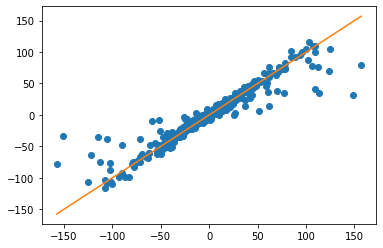

test mae:  0.5351530409500979
test rmse:  2.6453730218934908


In [15]:
forces_predictions_test = []
for key in test_coefficients.keys():
    test_coefficients[key].requires_grad = True
    
for coef_der_batch, central_batch, derivative_batch, coef_batch, _, structures_batch in iterate_minibatches(coef_der_test,
                                                    central_indices_test, derivative_indices_test, test_coefficients, None,
                                                   test_structures, BATCH_SIZE, DEVICE):
    forces_predictions_now = atomistic.get_forces(coef_der_batch, central_batch, derivative_batch,
                                                 coef_batch, get_central_species(structures_batch),
                                                  get_structural_indices(structures_batch))
    print(forces_predictions_now.shape)
    forces_predictions_test.append(forces_predictions_now)
    
forces_predictions_test = torch.cat(forces_predictions_test, dim = 0)
forces_predictions_a = forces_predictions_test.data.cpu().numpy().reshape([-1])
forces_a = test_forces.reshape([-1])
plt.plot(forces_a, forces_predictions_a, 'o')
plt.plot([np.min(forces_a), np.max(forces_a)],
         [np.min(forces_a), np.max(forces_a)])

plt.show()
print("test mae: ", get_mae(forces_a, forces_predictions_a))
print("test rmse: ", get_rmse(forces_a, forces_predictions_a))

In [16]:
class ListsWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ListsWrapper, self).__init__()
        self.model = model
        
    def forward(self, *X):
        coefs = {}
        for lambd in range(LAMBDA_MAX + 1):
            coefs[lambd] = X[lambd]
        central_ind = X[LAMBDA_MAX + 1]
        struc_ind = X[LAMBDA_MAX + 2]
        result = self.model(coefs, central_ind, struc_ind)
        return result['predictions']

In [17]:
atomistic = atomistic.to('cpu')
model_list = ListsWrapper(atomistic)
inputs = []
for lambd in range(LAMBDA_MAX + 1):
    inputs.append(test_coefficients[lambd])
inputs.append(torch.IntTensor(get_central_species(test_structures)))
inputs.append(torch.IntTensor(get_structural_indices(test_structures)))
result = model_list(*inputs)
print(result[0:10])

tensor([-1.8277, -3.1550, -1.4083,  0.3465, -3.1723, -1.9754,  1.8092,  1.5751,
        -0.4258, -1.5214], grad_fn=<SliceBackward>)


In [18]:
traced = torch.jit.trace(model_list, inputs, strict = False)
traced.save("sparse_kernel_model_list.pt")

In [19]:
coef_small = {}
for key in test_coefficients.keys():
    coef_small[key] = test_coefficients[key][0:50]
struc_ind_small = torch.IntTensor(get_structural_indices(test_structures)[0:50])
central_species_small = torch.IntTensor(get_central_species(test_structures)[0:50])

inputs_small = []
for lambd in range(LAMBDA_MAX + 1):
    inputs_small.append(coef_small[lambd])
inputs_small.append(central_species_small)
inputs_small.append(struc_ind_small)

In [20]:
!rm inputs/*

In [21]:
for i in tqdm.tqdm(range(len(inputs_small))):
    shape_now = inputs_small[i].shape
    now = inputs_small[i].reshape(-1)
    with open("inputs/{}".format(i), "w") as f:
        print(len(shape_now), file = f)
        for dim in shape_now:
            print(dim, file = f, end = ' ')
        print(file = f)
        for j in range(now.shape[0]):
            print(now[j].item(), file = f, end = ' ')
    

100%|██████████| 8/8 [00:00<00:00, 206.75it/s]


In [22]:
LIBTORCH_PATH = "/home/sergey/libtorch_installation/libtorch/"

In [23]:
!rm -r cpp_invoke/build/*
!cmake -DCMAKE_PREFIX_PATH=$LIBTORCH_PATH -H./cpp_invoke/ -B./cpp_invoke/build/
!cmake --build ./cpp_invoke/build/ --config Release

-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Found Torch: /home/sergey/libtorch_inst

In [24]:
!./cpp_invoke/build/run ./sparse_kernel_model_list.pt ./inputs

energies: -1.8277
-3.1550
-1.4083
 0.3465
-3.1723
-1.9754
 1.8092
 1.5751
-0.4258
-1.5214
[ CPUDoubleType{10} ]
ok
